# Week 14: Transformers

This notebook builds a complete transformer encoder from scratch. You'll implement positional encodings, multi-head self-attention, feed-forward networks, and residual connections to create a production-quality transformer architecture.

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import time
import seaborn as sns

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Display configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_style('whitegrid')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
import os
import pickle

# ── Cache helpers ─────────────────────────────────────────────────────────────
CACHE_DIR = "cache_week14"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] Loaded '{key}'")
        return result
    print(f"[cache] Computing '{key}' …")
    result = compute_fn()
    save_result(key, result)
    return result

def save_model(model, name):
    path = os.path.join(CACHE_DIR, f"{name}.pth")
    torch.save(model.state_dict(), path)
    print(f"[cache] Model saved → {path}")

def load_model_state(name):
    path = os.path.join(CACHE_DIR, f"{name}.pth")
    if os.path.exists(path):
        print(f"[cache] Model loaded ← {path}")
        return torch.load(path, weights_only=True)
    return None


## Exercise 1: Positional Encoding

Implement sinusoidal positional encodings to inject sequence order information.

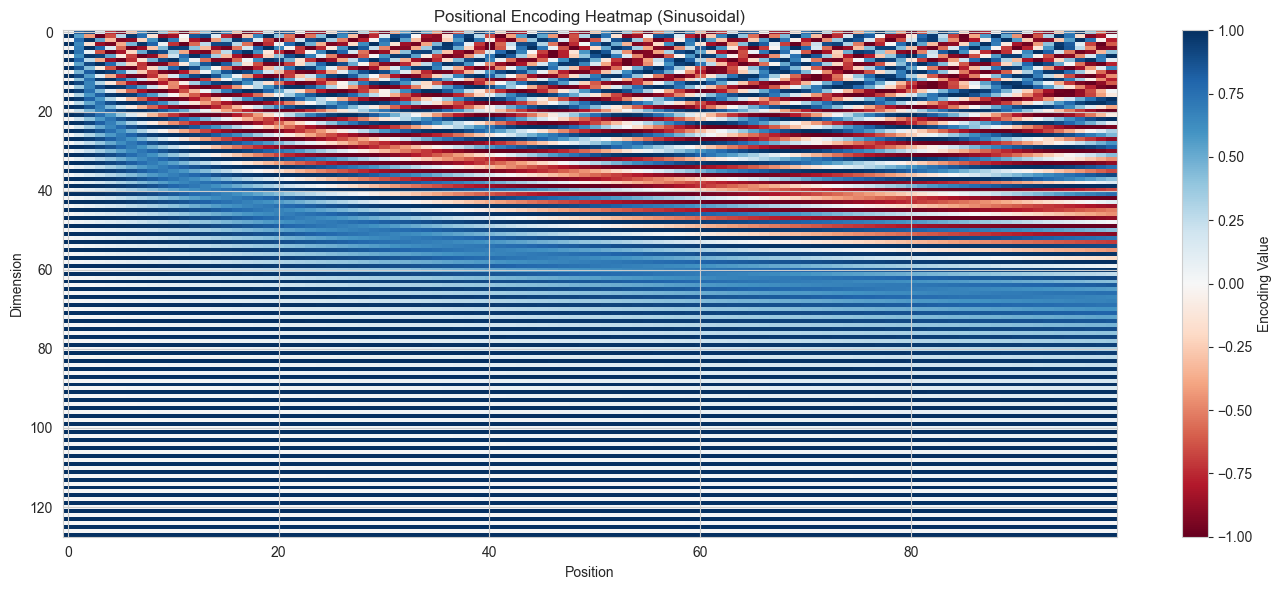

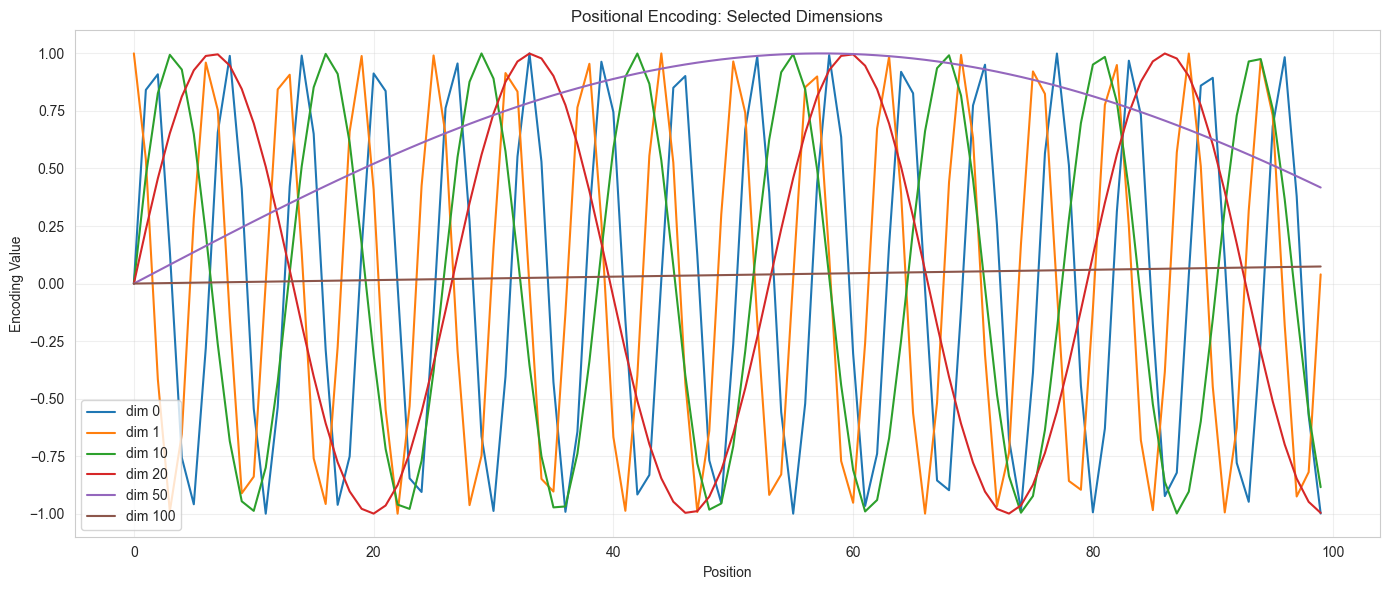

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)
        
        # Register as buffer (not a parameter, but part of state)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x + positional encoding
        """
        return x + self.pe[:, :x.size(1), :]

# Visualize positional encodings
d_model = 128
max_len = 100
pos_encoder = PositionalEncoding(d_model, max_len)

# Get positional encodings for visualization
dummy_input = torch.zeros(1, max_len, d_model)
pe_values = pos_encoder(dummy_input)[0].numpy()

plt.figure(figsize=(14, 6))
plt.imshow(pe_values.T, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Encoding Value')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding Heatmap (Sinusoidal)')
plt.tight_layout()
plt.show()

# Plot a few dimensions over positions
plt.figure(figsize=(14, 6))
for dim in [0, 1, 10, 20, 50, 100]:
    plt.plot(pe_values[:, dim], label=f'dim {dim}')
plt.xlabel('Position')
plt.ylabel('Encoding Value')
plt.title('Positional Encoding: Selected Dimensions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercise 2: Transformer Encoder Layer

Build a single transformer encoder layer with multi-head attention, feed-forward network, and residual connections.

In [4]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Multi-head self-attention
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Multi-head attention with residual connection
        attn_output, attn_weights = self.self_attn(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))
        
        return x, attn_weights

# Test the encoder layer
d_model = 128
num_heads = 8
d_ff = 512
batch_size, seq_len = 4, 20

encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff)
x = torch.randn(batch_size, seq_len, d_model)

output, attn_weights = encoder_layer(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"Number of parameters: {sum(p.numel() for p in encoder_layer.parameters()):,}")

Input shape: torch.Size([4, 20, 128])
Output shape: torch.Size([4, 20, 128])
Attention weights shape: torch.Size([4, 20, 20])
Number of parameters: 198,272


## Exercise 3: Complete Transformer Encoder

Stack multiple encoder layers with positional encoding and input embedding.

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len=5000, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        
        # Input embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        # Stack of encoder layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Dropout after embedding
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Embedding + positional encoding
        x = self.embedding(x) * np.sqrt(self.d_model)  # Scale embeddings
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # Pass through encoder layers
        attn_weights_list = []
        for layer in self.layers:
            x, attn_weights = layer(x, mask)
            attn_weights_list.append(attn_weights)
        
        return x, attn_weights_list

# Create a full transformer encoder
vocab_size = 1000
d_model = 128
num_heads = 8
d_ff = 512
num_layers = 6

transformer = TransformerEncoder(vocab_size, d_model, num_heads, d_ff, num_layers).to(device)

# Test with random input
batch_size, seq_len = 8, 25
input_ids = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)

output, attn_weights_list = transformer(input_ids)
print(f"Input IDs shape: {input_ids.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of attention weight tensors: {len(attn_weights_list)}")
print(f"Total parameters: {sum(p.numel() for p in transformer.parameters()):,}")

Input IDs shape: torch.Size([8, 25])
Output shape: torch.Size([8, 25, 128])
Number of attention weight tensors: 6
Total parameters: 1,317,632


## Exercise 4: Sequence Classification Task

Use the transformer encoder for a classification task (e.g., sentiment analysis proxy).

Epoch 1/5 - Train Loss: 1.1106, Val Acc: 0.3140
Epoch 2/5 - Train Loss: 1.1034, Val Acc: 0.3410
Epoch 3/5 - Train Loss: 1.0992, Val Acc: 0.3440
Epoch 4/5 - Train Loss: 1.0961, Val Acc: 0.3190
Epoch 5/5 - Train Loss: 1.0814, Val Acc: 0.3340
[cache] Model saved → cache_week14\transformer_classifier_5epochs.pth


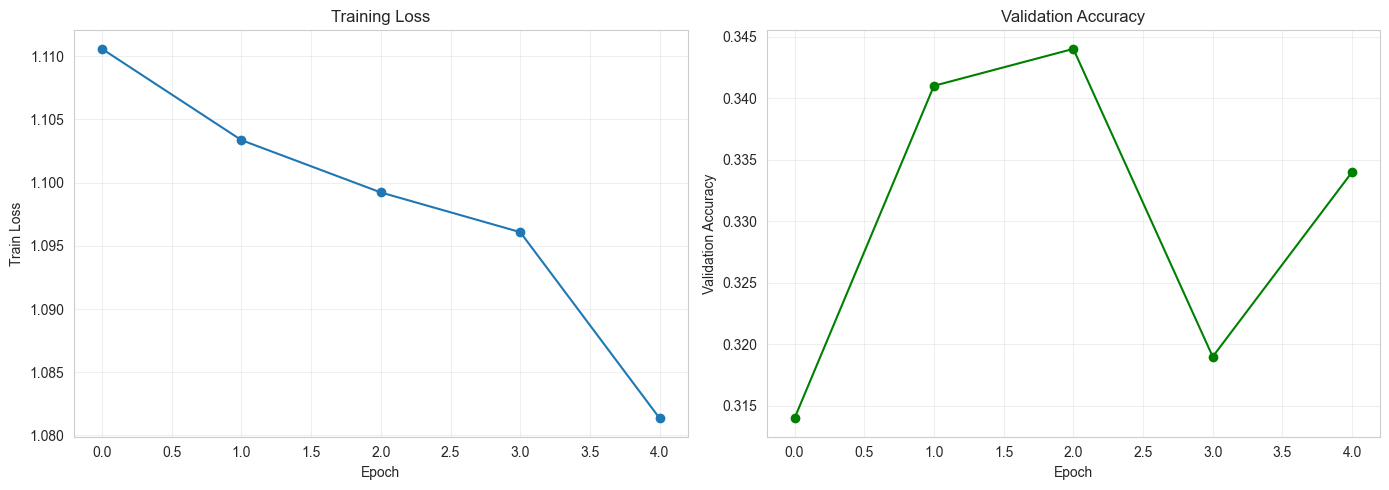

In [6]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        self.transformer = TransformerEncoder(vocab_size, d_model, num_heads, d_ff, num_layers, dropout=dropout)
        
        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        # Get transformer output
        encoder_output, _ = self.transformer(x)
        
        # Pool: use [CLS] token (first position) or mean pooling
        pooled = encoder_output.mean(dim=1)  # Mean pooling
        
        # Classify
        logits = self.classifier(pooled)
        return logits

# Create synthetic classification dataset
num_samples = 5000
seq_len = 30
vocab_size = 500
num_classes = 3

# Random sequences and labels
X = torch.randint(0, vocab_size, (num_samples, seq_len))
y = torch.randint(0, num_classes, (num_samples,))

# Split into train/val
split = int(0.8 * num_samples)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

CACHE_KEY = "transformer_classifier_5epochs"

_state = load_model_state(CACHE_KEY)
if _state is not None:
    model = TransformerClassifier(
        vocab_size=vocab_size, d_model=64, num_heads=4,
        d_ff=256, num_layers=3, num_classes=num_classes, dropout=0.1
    ).to(device)
    model.load_state_dict(_state)
    history = load_result(CACHE_KEY + "_history")
    print("[cache] TransformerClassifier and history loaded — skipping training.")
else:
    model = TransformerClassifier(
        vocab_size=vocab_size, d_model=64, num_heads=4,
        d_ff=256, num_layers=3, num_classes=num_classes, dropout=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 5
    history = {"train_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # Validate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                logits = model(batch_X)
                preds = logits.argmax(dim=1)
                correct += (preds == batch_y).sum().item()
                total += batch_y.size(0)

        val_acc = correct / total
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}")

    save_model(model, CACHE_KEY)
    save_result(CACHE_KEY + "_history", history)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history["train_loss"], marker='o')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Train Loss')
ax1.set_title('Training Loss'); ax1.grid(True, alpha=0.3)

ax2.plot(history["val_acc"], marker='o', color='green')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Validation Accuracy'); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Exercise 5: Computational Profiling

Measure memory usage and inference time for different transformer configurations.

[cache] Loaded 'transformer_profiling_5configs'


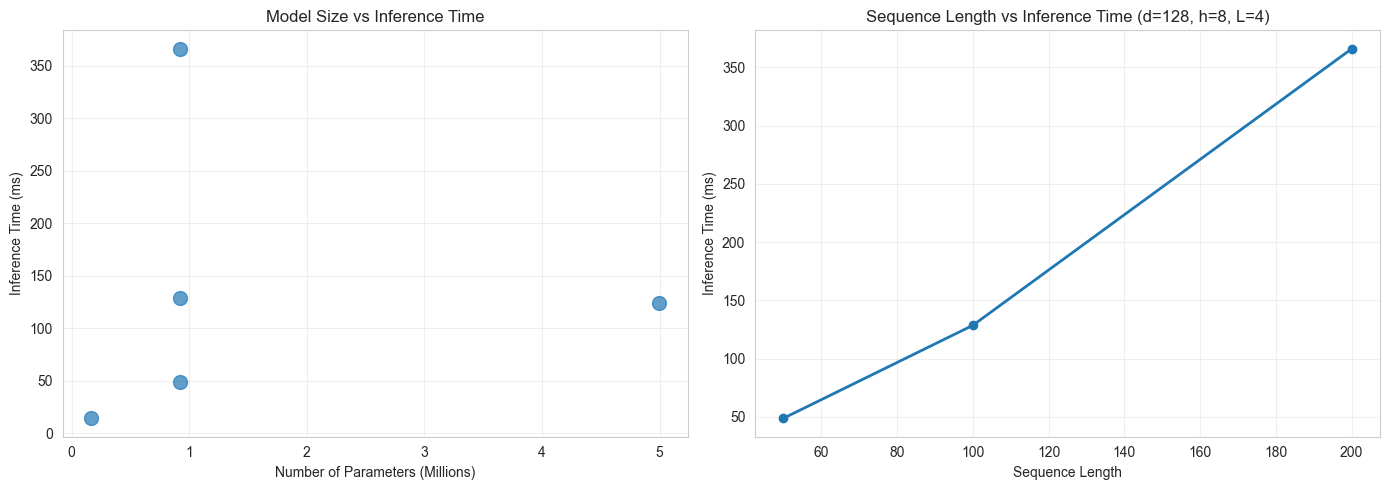

In [28]:
def profile_transformer(d_model, num_heads, num_layers, seq_len, batch_size=16):
    """Profile transformer performance."""
    model = TransformerEncoder(
        vocab_size=1000,
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_model * 4,
        num_layers=num_layers
    ).to(device)
    
    num_params = sum(p.numel() for p in model.parameters())
    x = torch.randint(0, 1000, (batch_size, seq_len)).to(device)
    
    # Warm-up
    for _ in range(3):
        _ = model(x)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    start = time.time()
    num_repeats = 50
    for _ in range(num_repeats):
        _ = model(x)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    elapsed = (time.time() - start) / num_repeats
    
    return {'num_params': num_params, 'inference_time_ms': elapsed * 1000}

configs = [
    {'d_model': 64,  'num_heads': 4, 'num_layers': 2, 'seq_len': 50},
    {'d_model': 128, 'num_heads': 8, 'num_layers': 4, 'seq_len': 50},
    {'d_model': 256, 'num_heads': 8, 'num_layers': 6, 'seq_len': 50},
    {'d_model': 128, 'num_heads': 8, 'num_layers': 4, 'seq_len': 100},
    {'d_model': 128, 'num_heads': 8, 'num_layers': 4, 'seq_len': 200},
]

def _run_profiling():
    results = []
    for config in configs:
        print(f"Profiling: {config}")
        result = profile_transformer(**config)
        result.update(config)
        results.append(result)
        print(f"  Params: {result['num_params']:,}, Time: {result['inference_time_ms']:.2f}ms")
    return results

results = cached("transformer_profiling_5configs", _run_profiling)

import polars as pl
df = pl.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(df['num_params'] / 1e6, df['inference_time_ms'], s=100, alpha=0.7)
ax1.set_xlabel('Number of Parameters (Millions)')
ax1.set_ylabel('Inference Time (ms)')
ax1.set_title('Model Size vs Inference Time')
ax1.grid(True, alpha=0.3)

same_model = df.filter(
    (pl.col("d_model") == 128)
    & (pl.col("num_heads") == 8)
    & (pl.col("num_layers") == 4)
)
ax2.plot(same_model['seq_len'], same_model['inference_time_ms'], marker='o', linewidth=2)
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Inference Time (ms)')
ax2.set_title('Sequence Length vs Inference Time (d=128, h=8, L=4)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Further Practice

1. **Decoder**: Implement a transformer decoder with causal masking
2. **Pre-LN vs Post-LN**: Compare pre-layer norm and post-layer norm architectures
3. **Learned Positional Encodings**: Replace sinusoidal encodings with learned embeddings
4. **Relative Positional Encodings**: Implement relative positional attention (T5-style)
5. **Flash Attention**: Explore efficient attention implementations for long sequences

## Deliverables

- [ ] Implement and visualize positional encodings
- [ ] Build transformer encoder layer from scratch
- [ ] Stack multiple layers into full transformer encoder
- [ ] Train transformer on classification task
- [ ] Profile computational costs (params, time, memory)
- [ ] Compare transformer with RNN/LSTM baselines

In [8]:

# EXERCISE 1 — Learned Positional Encodings
# Goal: replace the sinusoidal PositionalEncoding with a learned nn.Embedding(max_len, d_model).
# Train the TransformerClassifier with both encodings and compare val accuracy.
# Use cached("learned_pe_classifier_5epochs", ...) for the learned-PE training history.
# Expected insight: learned PE often matches sinusoidal on short sequences, but lacks extrapolation.


In [9]:

# EXERCISE 2 — Pre-LN vs Post-LN Transformer
# Goal: implement a Pre-LayerNorm encoder layer (norm before attention and FFN instead of after).
# Use cached("preln_classifier_5epochs", ...) and compare val accuracy with the Post-LN baseline.
# Plot both training-loss curves on one chart and note which stabilizes faster.
# Expected insight: Pre-LN training is more stable, especially in early epochs.


In [10]:

# EXERCISE 3 — Depth vs Width Scaling
# Goal: train 4 transformer variants (layers=2 vs 6, d_model=64 vs 128) for 5 epochs.
# Use cached(f"transformer_L{layers}_d{d_model}_5epochs", ...) per variant.
# Create a 2×2 grid of val-accuracy curves and measure parameter counts.
# Expected insight: depth generally helps more than width for sequence tasks with fixed param budget.


In [11]:

# EXERCISE 4 — Attention Weight Visualization per Layer
# Goal: after loading the cached TransformerClassifier, run one validation batch through the model.
# Collect the attention weight tensors returned by each encoder layer.
# For a single sample, plot one heatmap per layer (6 subplots) to see how attention evolves with depth.
# Use cached("attention_weight_visualizations", ...) to store the collected weight arrays.


## Recommended Resources

- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) (original paper)
- [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) (line-by-line implementation)
- [Illustrated Guide to Transformers](https://jalammar.github.io/illustrated-transformer/)
- [Formal Algorithms for Transformers](https://arxiv.org/abs/2207.09238) (comprehensive reference)